<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('capstone_user_identification/')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [18]:
import pickle
import re
from scipy.sparse import csr_matrix

def prepare_sparse_train_set_window(path_to_csv_files, 
                                    site_freq_path, 
                                    session_length=10, 
                                    window_size=10):

    results = np.zeros((session_length,))
    y = []
    with open(site_freq_path, 'rb') as file_site:
        site_to_num = pickle.load(file_site)
    site_to_num = {k:v[0] for k,v in site_to_num.items()}
    
    for file_name in glob(path_to_csv_files+'/*'):
        df = pd.read_csv(file_name)
        df.site = df.site.map(site_to_num)
        
        n = int(np.ceil(df.shape[0] /window_size).item())
        temp = df.site.values
        temp = np.append(temp, np.zeros(session_length-temp.shape[0]%window_size,))
        temp = np.lib.stride_tricks.as_strided(temp, shape=(n, session_length),
                                       strides=(8*window_size, 8))
        results = np.vstack([results, temp])
        y.extend(n*[int(re.findall(r'user(\d\d\d\d)', file_name)[0])])
        
    return get_sparse(results[1:, :]), np.array(y)
 
    
def get_sparse(docs):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            index = vocabulary.setdefault(term, term)
            indices.append(index)
            data.append(1)

        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int)[:,1:]  

In [304]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    results = np.zeros((session_length +session_length-1+ 5,))
    with open(site_freq_path, 'rb') as file_site:
        site_to_num = pickle.load(file_site)
    site_to_num = {k:v[0] for k,v in site_to_num.items()}
    
    for file_name in glob(path_to_csv_files+'/*'):
        df = pd.read_csv(file_name)
        df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%d %X')
        df.site = df.site.map(site_to_num)
        
        n = int(np.ceil(df.shape[0] /window_size).item())
        sites = df.site.values
        sites = np.append(sites, np.zeros(session_length-sites.shape[0]%window_size,))
        sites = np.lib.stride_tricks.as_strided(sites, shape=(n, session_length),
                                       strides=(8*window_size, 8))
        
        timestamps = df.timestamp.values
        empty_shape = session_length-timestamps.shape[0]%window_size
        timestamps = np.append(timestamps, 
                               np.array([np.datetime64('nat')]*empty_shape)
                               )
        timestamps = np.lib.stride_tricks.as_strided(timestamps, shape=(n, session_length),
                                       strides=(8*window_size, 8))
        
        '''session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
        unique_sites – число уникальных сайтов в сессии
        start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
        day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)
        '''
        timestamps = pd.DataFrame(timestamps)
        to_add = pd.DataFrame()
        to_add['timespan'] = (timestamps.max(axis=1) - \
                                    timestamps.min(axis=1)).dt.seconds
        temp = pd.DataFrame(sites)
        to_add['unique'] = temp[temp.ne(0)].nunique(axis=1)
        to_add['hour'] = timestamps.min(axis=1).dt.hour
        to_add['dayweek'] = timestamps.min().dt.dayofweek
        to_add['y'] = int(re.findall(r'user(\d\d\d\d)', file_name)[0])
        
        timestamps = timestamps.apply(lambda x: 
                                      x.dropna().astype('int').diff()/10**9,
                                      axis=1)
        timestamps = timestamps.shift(-1, axis=1, fill_value=0).fillna(0)
        if timestamps.shape[1] != session_length-1:
            timestamps = np.concatenate([timestamps.values,
                                         np.zeros((timestamps.shape[0],
                                                   session_length - timestamps.shape[1]))],
                                        axis=1)
        to_add = np.concatenate([sites, timestamps[:,:-1], to_add.values], 
                                axis=1)
        results = np.vstack([results, to_add])
        
    return pd.DataFrame(results[1:, :], columns=feature_names)
 

**Проверим функцию на игрушечном примере.**

In [307]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [308]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4.0,2.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
1,4.0,2.0,2.0,9.0,2.0,1.0,11.0,5.0,10.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
2,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
3,3.0,1.0,2.0,1.0,2.0,1.0,1.0,5.0,7.0,3.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [309]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 14.6 s, sys: 317 ms, total: 14.9 s
Wall time: 15.5 s


In [310]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,60.0,60.0,266.0,39.0,39.0,69.0,162.0,69.0,183.0,160.0,2.0,3.0,282.0,4.0,2.0,1.0,0.0,686.0,0.0,980.0,7.0,21.0,6.0,241.0
1,168.0,164.0,81.0,310.0,168.0,183.0,164.0,160.0,81.0,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,5.0,7.0,22.0,6.0,241.0
2,39.0,60.0,60.0,266.0,39.0,39.0,193.0,81.0,183.0,164.0,417673.0,2.0,2.0,284.0,171.0,3669.0,2.0,1.0,0.0,76204.0,7.0,20.0,6.0,241.0
3,160.0,168.0,310.0,61.0,2.0,6.0,3.0,2.0,6.0,3.0,0.0,0.0,4.0,1.0,1.0,1.0,45.0,0.0,0.0,52.0,7.0,17.0,6.0,241.0
4,1650.0,3.0,2603.0,2.0,1650.0,2.0,3.0,2832.0,81.0,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,126.0,0.0,127.0,7.0,17.0,6.0,241.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [311]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2min 32s, sys: 1.17 s, total: 2min 34s
Wall time: 2min 35s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [313]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']]

In [315]:
time_features_10_users = train_data_10users[['time_diff' + str(j) 
                                             for j in range(1,10)]]
time_features_150_users = train_data_150users[['time_diff' + str(j) 
                                             for j in range(1,10)]]

In [316]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

In [319]:
with open(os.path.join(PATH_TO_DATA, 
                       'time_features_10users.pkl'), 'wb') as time_features_10users_pkl:
    pickle.dump(time_features_10_users, time_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'time_features_150users.pkl'), 'wb') as time_features_150users_pkl:
    pickle.dump(time_features_150_users, time_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [320]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [321]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

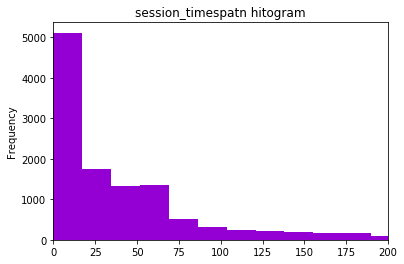

In [332]:
train_data_10users['session_timespan'].plot(kind='hist', title='session_timespan hitogram',
                                           xlim=(0,200), bins=5000, color='darkviolet');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

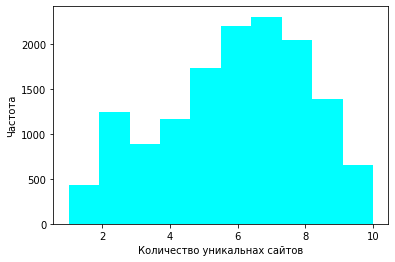

In [341]:
fig = train_data_10users['#unique_sites'].plot(kind='hist', color='aqua')
fig.set_xlabel('Количество уникальнах сайтов')
fig.set_ylabel('Частота')
fig;

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

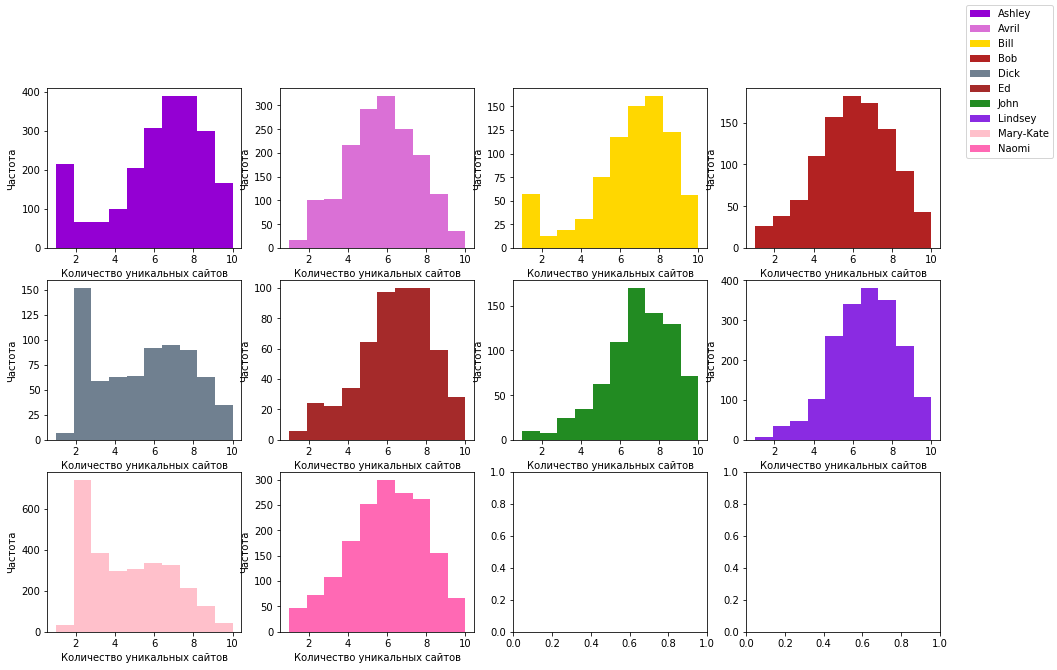

In [362]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for (user, sub_df), ax in  zip(train_data_10users.groupby('target'),
                               axes.ravel()): 
    sub_df['#unique_sites'].plot(kind='hist', ax=ax, color=color_dic[user], label=user)
    ax.set_xlabel('Количество уникальных сайтов')
    ax.set_ylabel('Частота')
fig.legend();
    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Частота')

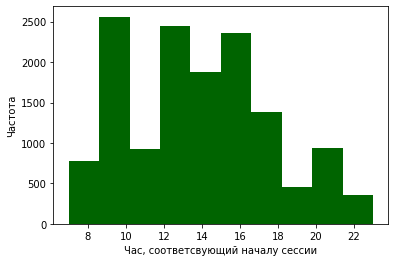

In [363]:
fig = train_data_10users['start_hour'].plot(kind='hist', color='darkgreen')
fig.set_xlabel('Час, соответсвующий началу сессии')
fig.set_ylabel('Частота');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

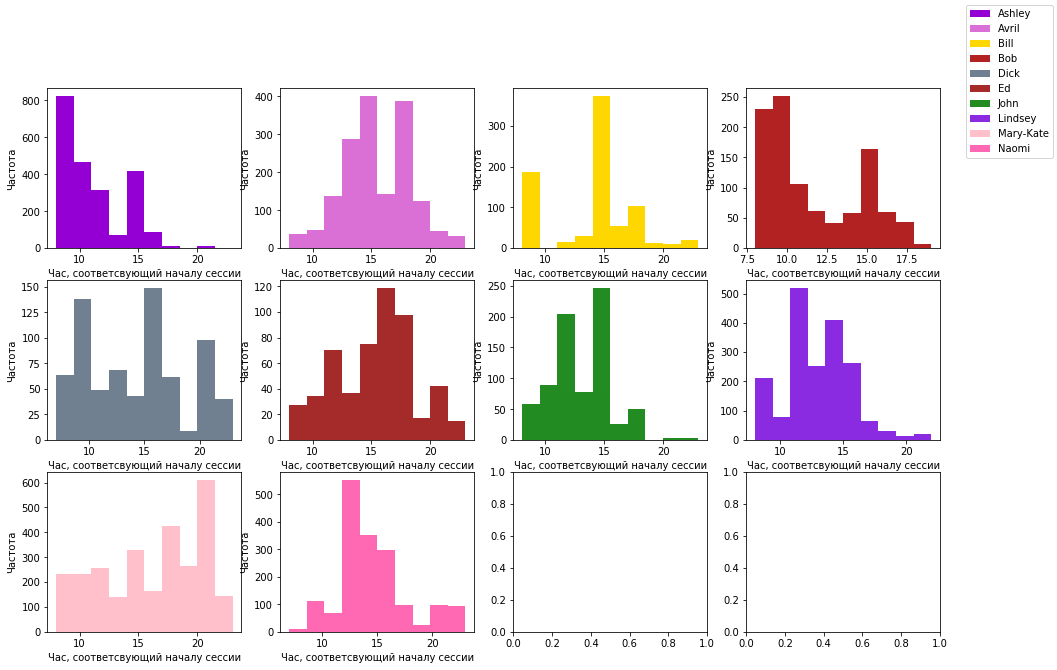

In [370]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for (user, sub_df), ax in  zip(train_data_10users.groupby('target'), axes.ravel()): 
    sub_df['start_hour'].plot(kind='hist', ax=ax, color=color_dic[user], label=user)
    ax.set_xlabel('Час, соответсвующий началу сессии')
    ax.set_ylabel('Частота')
fig.legend();

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

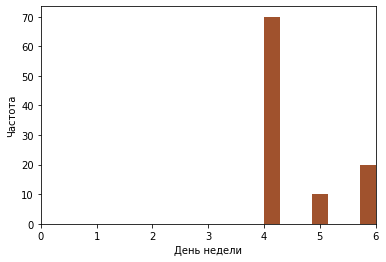

In [380]:
fig = train_data_10users['day_of_week'].plot(kind='hist', color='sienna',
                                            xlim=(0,6), bins=7)
fig.set_xlabel('День недели')
fig.set_ylabel('Частота');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

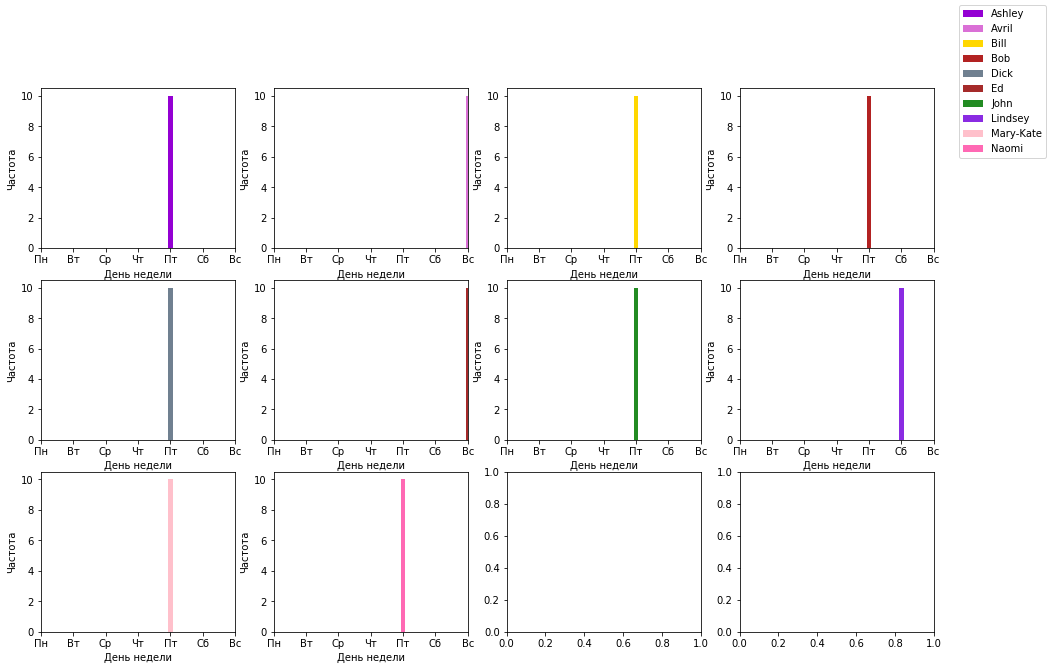

In [379]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for (user, sub_df), ax in  zip(train_data_10users.groupby('target'), axes.ravel()): 
    sub_df['day_of_week'].plot(kind='hist', ax=ax, color=color_dic[user], label=user,
                              xlim=(0,6), bins=7)
    ax.set_xlabel('День недели')
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.set_ylabel('Частота')
fig.legend();

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Пользователей можно разделить на группы по форме распределений их признаков
* день недели - большинство пользователей начали свои сессии в пятницы и лишь небольшое количество пользователей начали сессии в выходные
* час, соответсвующий началу - каждому пользователю соответсвует свое распределние: близкое к нормальному со средним в центре дня или скошенные вправо\влево, т.е. с медианой в начале или конце дня
* колчисетво йникальных сайтов - большинство пользователй имеют распределние скошенное влево, т.е в большитсве случаев такие пользователи имеют близкое к максимальному количество уникальных сайтов. Но так же есть пара пользователей с болшим количеством значений уникальных сатов близким к 0.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [385]:
with open(PATH_TO_DATA+'site_freq_10users.pkl', 'rb') as f:
    site_to_freq_10users = pickle.load(f)
    
site_to_freq_10users

{'s.youtube.com': (1, 8300),
 'www.google.fr': (2, 7813),
 'www.google.com': (3, 5441),
 'mail.google.com': (4, 4158),
 'www.facebook.com': (5, 4141),
 'apis.google.com': (6, 3758),
 'r3---sn-gxo5uxg-jqbe.googlevideo.com': (7, 3244),
 'r1---sn-gxo5uxg-jqbe.googlevideo.com': (8, 3094),
 'plus.google.com': (9, 2630),
 'accounts.google.com': (10, 2089),
 'r2---sn-gxo5uxg-jqbe.googlevideo.com': (11, 1939),
 'fr-mg42.mail.yahoo.com': (12, 1868),
 'www.youtube.com': (13, 1804),
 'r4---sn-gxo5uxg-jqbe.googlevideo.com': (14, 1702),
 'clients1.google.com': (15, 1493),
 'download.jboss.org': (16, 1441),
 's-static.ak.facebook.com': (17, 1388),
 'static.ak.facebook.com': (18, 1265),
 'i1.ytimg.com': (19, 1232),
 'twitter.com': (20, 1204),
 'accounts.youtube.com': (21, 1057),
 'platform.twitter.com': (22, 1041),
 'safebrowsing-cache.google.com': (23, 1039),
 'clients6.google.com': (24, 1039),
 'translate.google.fr': (25, 1002),
 'api.twitter.com': (26, 982),
 'accounts.google.fr': (27, 974),
 'tal

In [398]:
top10_sites = list(site_to_freq_10users.keys())[:10]
top10_freqs = [k[1] for k in site_to_freq_10users.values()][:10]
top10_sites, top10_freqs

(['s.youtube.com',
  'www.google.fr',
  'www.google.com',
  'mail.google.com',
  'www.facebook.com',
  'apis.google.com',
  'r3---sn-gxo5uxg-jqbe.googlevideo.com',
  'r1---sn-gxo5uxg-jqbe.googlevideo.com',
  'plus.google.com',
  'accounts.google.com'],
 [8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

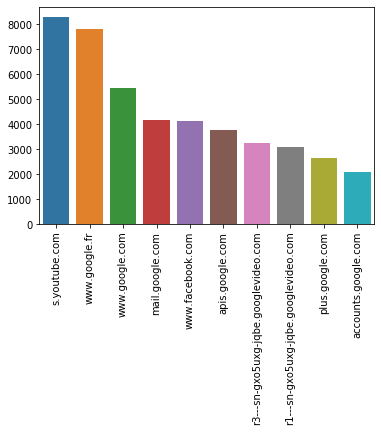

In [404]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation='vertical');

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [405]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [406]:
train_data_10users.day_of_week.median() 

4.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [407]:
train_data_150users.start_hour.median() 

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [408]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [580]:
def feature_engineering(path_to_csv_files, results,  session_length=10):
#     results = np.zeros((session_length +session_length-1+ 5,))
#     with open(site_freq_path, 'rb') as file_site:
#         site_to_num = pickle.load(file_site)
#     site_to_num = {k:v[0] for k,v in site_to_num.items()}
    
#     for file_name in glob(path_to_csv_files+'/*'):
#         df = pd.read_csv(file_name)
#         df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%d %X')
#         df.site = df.site.map(site_to_num)
        
#         n = int(np.ceil(df.shape[0] /window_size).item())
#         sites = df.site.values
#         sites = np.append(sites, np.zeros(session_length-sites.shape[0]%window_size,))
#         sites = np.lib.stride_tricks.as_strided(sites, shape=(n, session_length),
#                                        strides=(8*window_size, 8))
        
#         timestamps = df.timestamp.values
#         empty_shape = session_length-timestamps.shape[0]%window_size
#         timestamps = np.append(timestamps, 
#                                np.array([np.datetime64('nat')]*empty_shape)
#                                )
#         timestamps = np.lib.stride_tricks.as_strided(timestamps, shape=(n, session_length),
#                                        strides=(8*window_size, 8))
        
#         timestamps = pd.DataFrame(timestamps)
#         to_add = pd.DataFrame()
#         to_add['timespan'] = (timestamps.max(axis=1) - \
#                                     timestamps.min(axis=1)).dt.seconds
#         temp = pd.DataFrame(sites)
#         to_add['unique'] = temp[temp.ne(0)].nunique(axis=1)
#         to_add['hour'] = timestamps.min(axis=1).dt.hour
#         to_add['dayweek'] = timestamps.min().dt.dayofweek
#         to_add['y'] = int(re.findall(r'user(\d\d\d\d)', file_name)[0])
        
#         timestamps = timestamps.apply(lambda x: 
#                                       x.dropna().astype('int').diff()/10**9,
#                                       axis=1)
#         timestamps = timestamps.shift(-1, axis=1, fill_value=0).fillna(0)
#         if timestamps.shape[1] != session_length-1:
#             timestamps = np.concatenate([timestamps.values,
#                                          np.zeros((timestamps.shape[0],
#                                                    session_length - timestamps.shape[1]))],
#                                         axis=1)
#         to_add = np.concatenate([sites, timestamps[:,:-1], to_add.values], 
#                                 axis=1)
#         results = pd.DataFrame(np.vstack([results, to_add])[1:, :], columns=feature_names)
        
    to_add = pd.DataFrame()
    to_add['target'] = results.target
    to_add['part_day'] = pd.cut(x=results.start_hour, bins=[0,7,12,18,24],
                                include_lowest=True, labels=[0,1,2,3]).astype('int')
    to_add['start_hour_median'] = results.groupby('target').start_hour.transform(np.median)
    to_add['part_day_median'] = pd.cut(x=to_add.start_hour_median, bins=[0,7,12,18,24],
                                include_lowest=True, labels=[0,1,2,3]).astype('int')
    to_add['hour_in_median_part_day'] = (to_add.part_day == to_add.part_day_median).astype('int')
    
    top3 = results.groupby('target').start_hour \
                .agg(lambda x: x.value_counts().nlargest(3).index.tolist())
    top3 = pd.DataFrame(top3.tolist(), columns=['top_hour'+str(i) for i in range(1,4)],
                       index=top3.index)
    to_add = to_add.merge(top3, on='target', how='left')
    to_add['start_hour_in_top'] = ((results.start_hour == to_add.top_hour1) | \
                                    (results.start_hour == to_add.top_hour2) | \
                                    (results.start_hour == to_add.top_hour2)).astype('int')
#     display(to_add)
    
    
        
    
        
    return to_add
 

In [581]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
#                   site_freq_path=os.path.join(PATH_TO_DATA, 
#                                               'site_freq_150users.pkl'),
                  train_data_10users, session_length=10)

In [582]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
#                   site_freq_path=os.path.join(PATH_TO_DATA, 
#                                               'site_freq_150users.pkl'),
                  train_data_150users, session_length=10)
new_features_10users

,target,part_day,start_hour_median,part_day_median,hour_in_median_part_day,top_hour1,top_hour2,top_hour3,start_hour_in_top
0,Ed,3,16.0,2,0,16.0,17.0,15.0,0
1,Ed,3,16.0,2,0,16.0,17.0,15.0,0
2,Ed,3,16.0,2,0,16.0,17.0,15.0,0
3,Ed,2,16.0,2,1,16.0,17.0,15.0,1
4,Ed,2,16.0,2,1,16.0,17.0,15.0,1
...,...,...,...,...,...,...,...,...,...
14056,John,2,13.0,2,1,15.0,12.0,14.0,0
14057,John,2,13.0,2,1,15.0,12.0,14.0,0
14058,John,2,13.0,2,1,15.0,12.0,14.0,0
14059,John,2,13.0,2,1,15.0,12.0,14.0,0


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

(14061, 9)


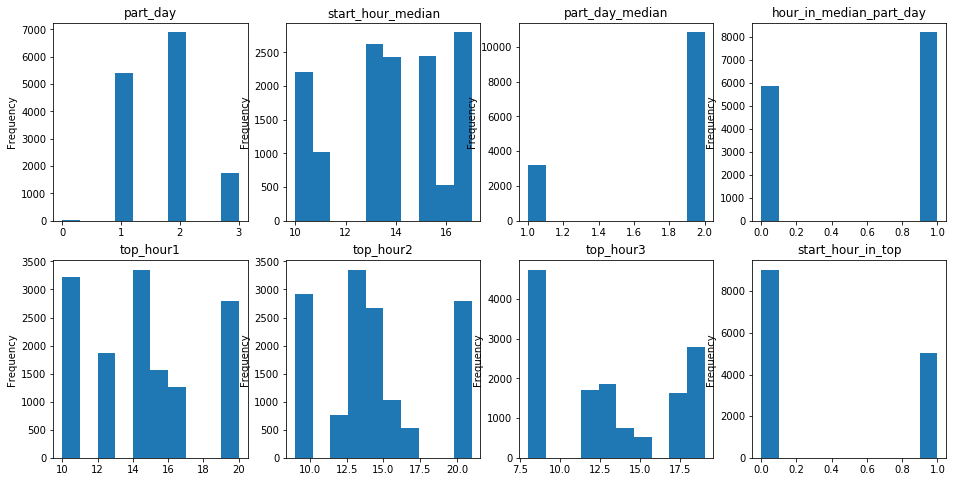

In [584]:
print(new_features_10users.shape)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for feature, ax in zip(new_features_10users.columns[1:], axes.ravel()):
    
    new_features_10users[feature].plot(kind='hist', title=feature, ax=ax)

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [585]:
selected_features_10users = new_features_10users 
selected_features_150users = new_features_150users 

In [586]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 